In [1]:
import pyspark as ps
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.types import *


%matplotlib inline

In [2]:
# Spark Session Set Up
spark = (ps.sql.SparkSession.builder
        .master("local[4]")
        .appName("spark-case-study")
        .getOrCreate())
sc = spark.sparkContext

In [5]:
# Read json data 
df_tweets = spark.read.json('../data/french_tweets.json')
df_tweets.take(1)

[Row(contributors=None, coordinates=None, created_at='Wed Apr 26 13:30:45 +0000 2017', display_text_range=None, entities=Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[]), extended_entities=None, extended_tweet=None, favorite_count=0, favorited=False, filter_level='low', geo=None, id=857225437122097152, id_str='857225437122097152', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=False, lang='fr', limit=None, place=Row(bounding_box=Row(coordinates=[[[-0.061141, 49.208997], [-0.061141, 49.250115], [-0.032199, 49.250115], [-0.032199, 49.208997]]], type='Polygon'), country='France', country_code='FR', full_name='Dozulé, France', id='4da693e9b39923ab', name='Dozulé', place_type='city', url='https://api.twitter.com/1.1/geo/id/4da693e9b39923ab.json'), possibly_sensitive=None, quoted_status=None, quoted_status_id=None, quoted_status_id_str=None, retweet_count=0, r

In [6]:
# Create an id column 
df = df_tweets.withColumn("m_id", F.monotonically_increasing_id())

In [7]:
df.take(1)

[Row(contributors=None, coordinates=None, created_at='Wed Apr 26 13:30:45 +0000 2017', display_text_range=None, entities=Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[]), extended_entities=None, extended_tweet=None, favorite_count=0, favorited=False, filter_level='low', geo=None, id=857225437122097152, id_str='857225437122097152', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=False, lang='fr', limit=None, place=Row(bounding_box=Row(coordinates=[[[-0.061141, 49.208997], [-0.061141, 49.250115], [-0.032199, 49.250115], [-0.032199, 49.208997]]], type='Polygon'), country='France', country_code='FR', full_name='Dozulé, France', id='4da693e9b39923ab', name='Dozulé', place_type='city', url='https://api.twitter.com/1.1/geo/id/4da693e9b39923ab.json'), possibly_sensitive=None, quoted_status=None, quoted_status_id=None, quoted_status_id_str=None, retweet_count=0, r

In [8]:
# Create a new table view 
df.createOrReplaceTempView('tweets')

In [9]:
query = """SELECT m_id, place.country as country, place.country_code as country_code,
            favorite_count, favorited, filter_level, id, id_str, in_reply_to_screen_name, 
            in_reply_to_status_id, in_reply_to_status_id_str, in_reply_to_user_id, in_reply_to_user_id_str, 
            is_quote_status, lang,possibly_sensitive, quoted_status, quoted_status_id_str, retweet_count, retweeted, text, timestamp_ms, quoted_status_id
            FROM tweets"""

dfn = spark.sql(query)

In [10]:
dfn.take(1)

[Row(m_id=0, country='France', country_code='FR', favorite_count=0, favorited=False, filter_level='low', id=857225437122097152, id_str='857225437122097152', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=False, lang='fr', possibly_sensitive=None, quoted_status=None, quoted_status_id_str=None, retweet_count=0, retweeted=False, text='Je comprends pas trop la fin de 13 reasons why 😓', timestamp_ms='1493213445345', quoted_status_id=None)]

In [11]:
##########
# hashtags cleaner function
def hashtags(h):
    if h:
        return ' '.join(h)
    else:
        return ''
hashtags_udf = F.udf(hashtags, StringType())

# add hashtags column
df_with_id = df.withColumn("hashtags", hashtags_udf(df["entities.hashtags.text"]))

# create tweets table
df_with_id.createOrReplaceTempView('tweets')

'''
# Create word Cloud
hashtags = spark.sql("""SELECT hashtags FROM tweets""")
text = ''
for hash in hashtags.collect():
    text += hash.asDict()['hashtags']

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)

# Plot
plot_cloud(wordcloud)
'''

'\n# Create word Cloud\nhashtags = spark.sql("""SELECT hashtags FROM tweets""")\ntext = \'\'\nfor hash in hashtags.collect():\n    text += hash.asDict()[\'hashtags\']\n\n# Define a function to plot word cloud\ndef plot_cloud(wordcloud):\n    # Set figure size\n    plt.figure(figsize=(40, 30))\n    # Display image\n    plt.imshow(wordcloud) \n    # No axis details\n    plt.axis("off");\n    \n# Generate word cloud\nwordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color=\'salmon\', colormap=\'Pastel1\', collocations=False, stopwords = STOPWORDS).generate(text)\n\n# Plot\nplot_cloud(wordcloud)\n'

In [12]:
dfv = df_with_id.select('m_id','hashtags')
dfv.take(1)

[Row(m_id=0, hashtags='')]

In [13]:
# Create new table 
df.createOrReplaceTempView('tweets')
query_a1 = """SELECT m_id, 
            user.contributors_enabled as user_contributors_enabled,
            user.created_at as user_created_at,
            user.default_profile_image as user_default_profile_image,
            user.description as user_description,
            user.favourites_count as user_favourites_count,
            user.follow_request_sent as user_follow_request_sent,
            user.followers_count as user_followers_count,
            user.following as user_following,
            user.friends_count as user_friends_count,
            user.id as user_id,
            user.lang as user_lang,
            user.listed_count as user_listed_count,
            user.location as user_location,
            user.name as user_name,
            user.screen_name as user_screen_name,
            user.statuses_count as user_statuses_count,
            user.time_zone as user_time_zone,
            user.verified as user_verified
            FROM tweets
            """
dfa = spark.sql(query_a1)
dfa.take(1)

[Row(m_id=0, user_contributors_enabled=False, user_created_at='Sun Apr 05 16:03:00 +0000 2015', user_default_profile_image=False, user_description=None, user_favourites_count=777, user_follow_request_sent=None, user_followers_count=318, user_following=None, user_friends_count=406, user_id=3137428743, user_lang='fr', user_listed_count=2, user_location=None, user_name='TAÏNA♡', user_screen_name='tainabmn', user_statuses_count=3251, user_time_zone=None, user_verified=False)]

In [14]:
# Create different tables for merging 
dfa.createOrReplaceTempView('tweets_a')
dfv.createOrReplaceTempView('tweets_v')
dfn.createOrReplaceTempView('tweets_n')

In [15]:
# Join all table 
query2 = """SELECT * FROM tweets_n n
            LEFT JOIN tweets_a a
                ON n.m_id = a.m_id
            LEFT JOIN tweets_v v 
                ON n.m_id = v.m_id
    """
dfm = spark.sql(query2)
dfm.take(1)

[Row(m_id=8589934592, country='France', country_code='FR', favorite_count=0, favorited=False, filter_level='low', id=857501461365829632, id_str='857501461365829632', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=False, lang='en', possibly_sensitive=False, quoted_status=None, quoted_status_id_str=None, retweet_count=0, retweeted=False, text='Here were are on my way to Italy #caxtonlife https://t.co/7cC3kqK9bW', timestamp_ms='1493279254653', quoted_status_id=None, m_id=8589934592, user_contributors_enabled=False, user_created_at='Sun Dec 14 15:55:54 +0000 2014', user_default_profile_image=False, user_description='Adventure Cyclist, World Record Breaker, Inspirational Speaker, Spin Instructor and Blogger #TcrNo5 and #WRAttempt most Countries Cycled 7 Days 2017!', user_favourites_count=4409, user_follow_request_sent=None, user_followers_count=22069, user_following=None, user_

In [16]:
dfm.take(1)[0].asDict()

{'m_id': 8589934592,
 'country': 'France',
 'country_code': 'FR',
 'favorite_count': 0,
 'favorited': False,
 'filter_level': 'low',
 'id': 857501461365829632,
 'id_str': '857501461365829632',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'possibly_sensitive': False,
 'quoted_status': None,
 'quoted_status_id_str': None,
 'retweet_count': 0,
 'retweeted': False,
 'text': 'Here were are on my way to Italy #caxtonlife https://t.co/7cC3kqK9bW',
 'timestamp_ms': '1493279254653',
 'quoted_status_id': None,
 'user_contributors_enabled': False,
 'user_created_at': 'Sun Dec 14 15:55:54 +0000 2014',
 'user_default_profile_image': False,
 'user_description': 'Adventure Cyclist, World Record Breaker, Inspirational Speaker, Spin Instructor and Blogger #TcrNo5 and #WRAttempt most Countries Cycled 7 Days 2017!',
 'user_favourites_count': 4

In [17]:
# Save data as csv file 44 columns 
dfm.toPandas().to_csv('tweets.csv', sep = "|")

In [165]:
dfm.describe()

DataFrame[summary: string, m_id: string, country: string, country_code: string, favorite_count: string, filter_level: string, id: string, id_str: string, in_reply_to_screen_name: string, in_reply_to_status_id: string, in_reply_to_status_id_str: string, in_reply_to_user_id: string, in_reply_to_user_id_str: string, lang: string, quoted_status_id_str: string, retweet_count: string, text: string, timestamp_ms: string, quoted_status_id: string, m_id: string, user_created_at: string, user_description: string, user_favourites_count: string, user_follow_request_sent: string, user_followers_count: string, user_following: string, user_friends_count: string, user_id: string, user_lang: string, user_listed_count: string, user_location: string, user_name: string, user_screen_name: string, user_statuses_count: string, user_time_zone: string, m_id: string, hashtags: string]

## Hashtag Wordcloud

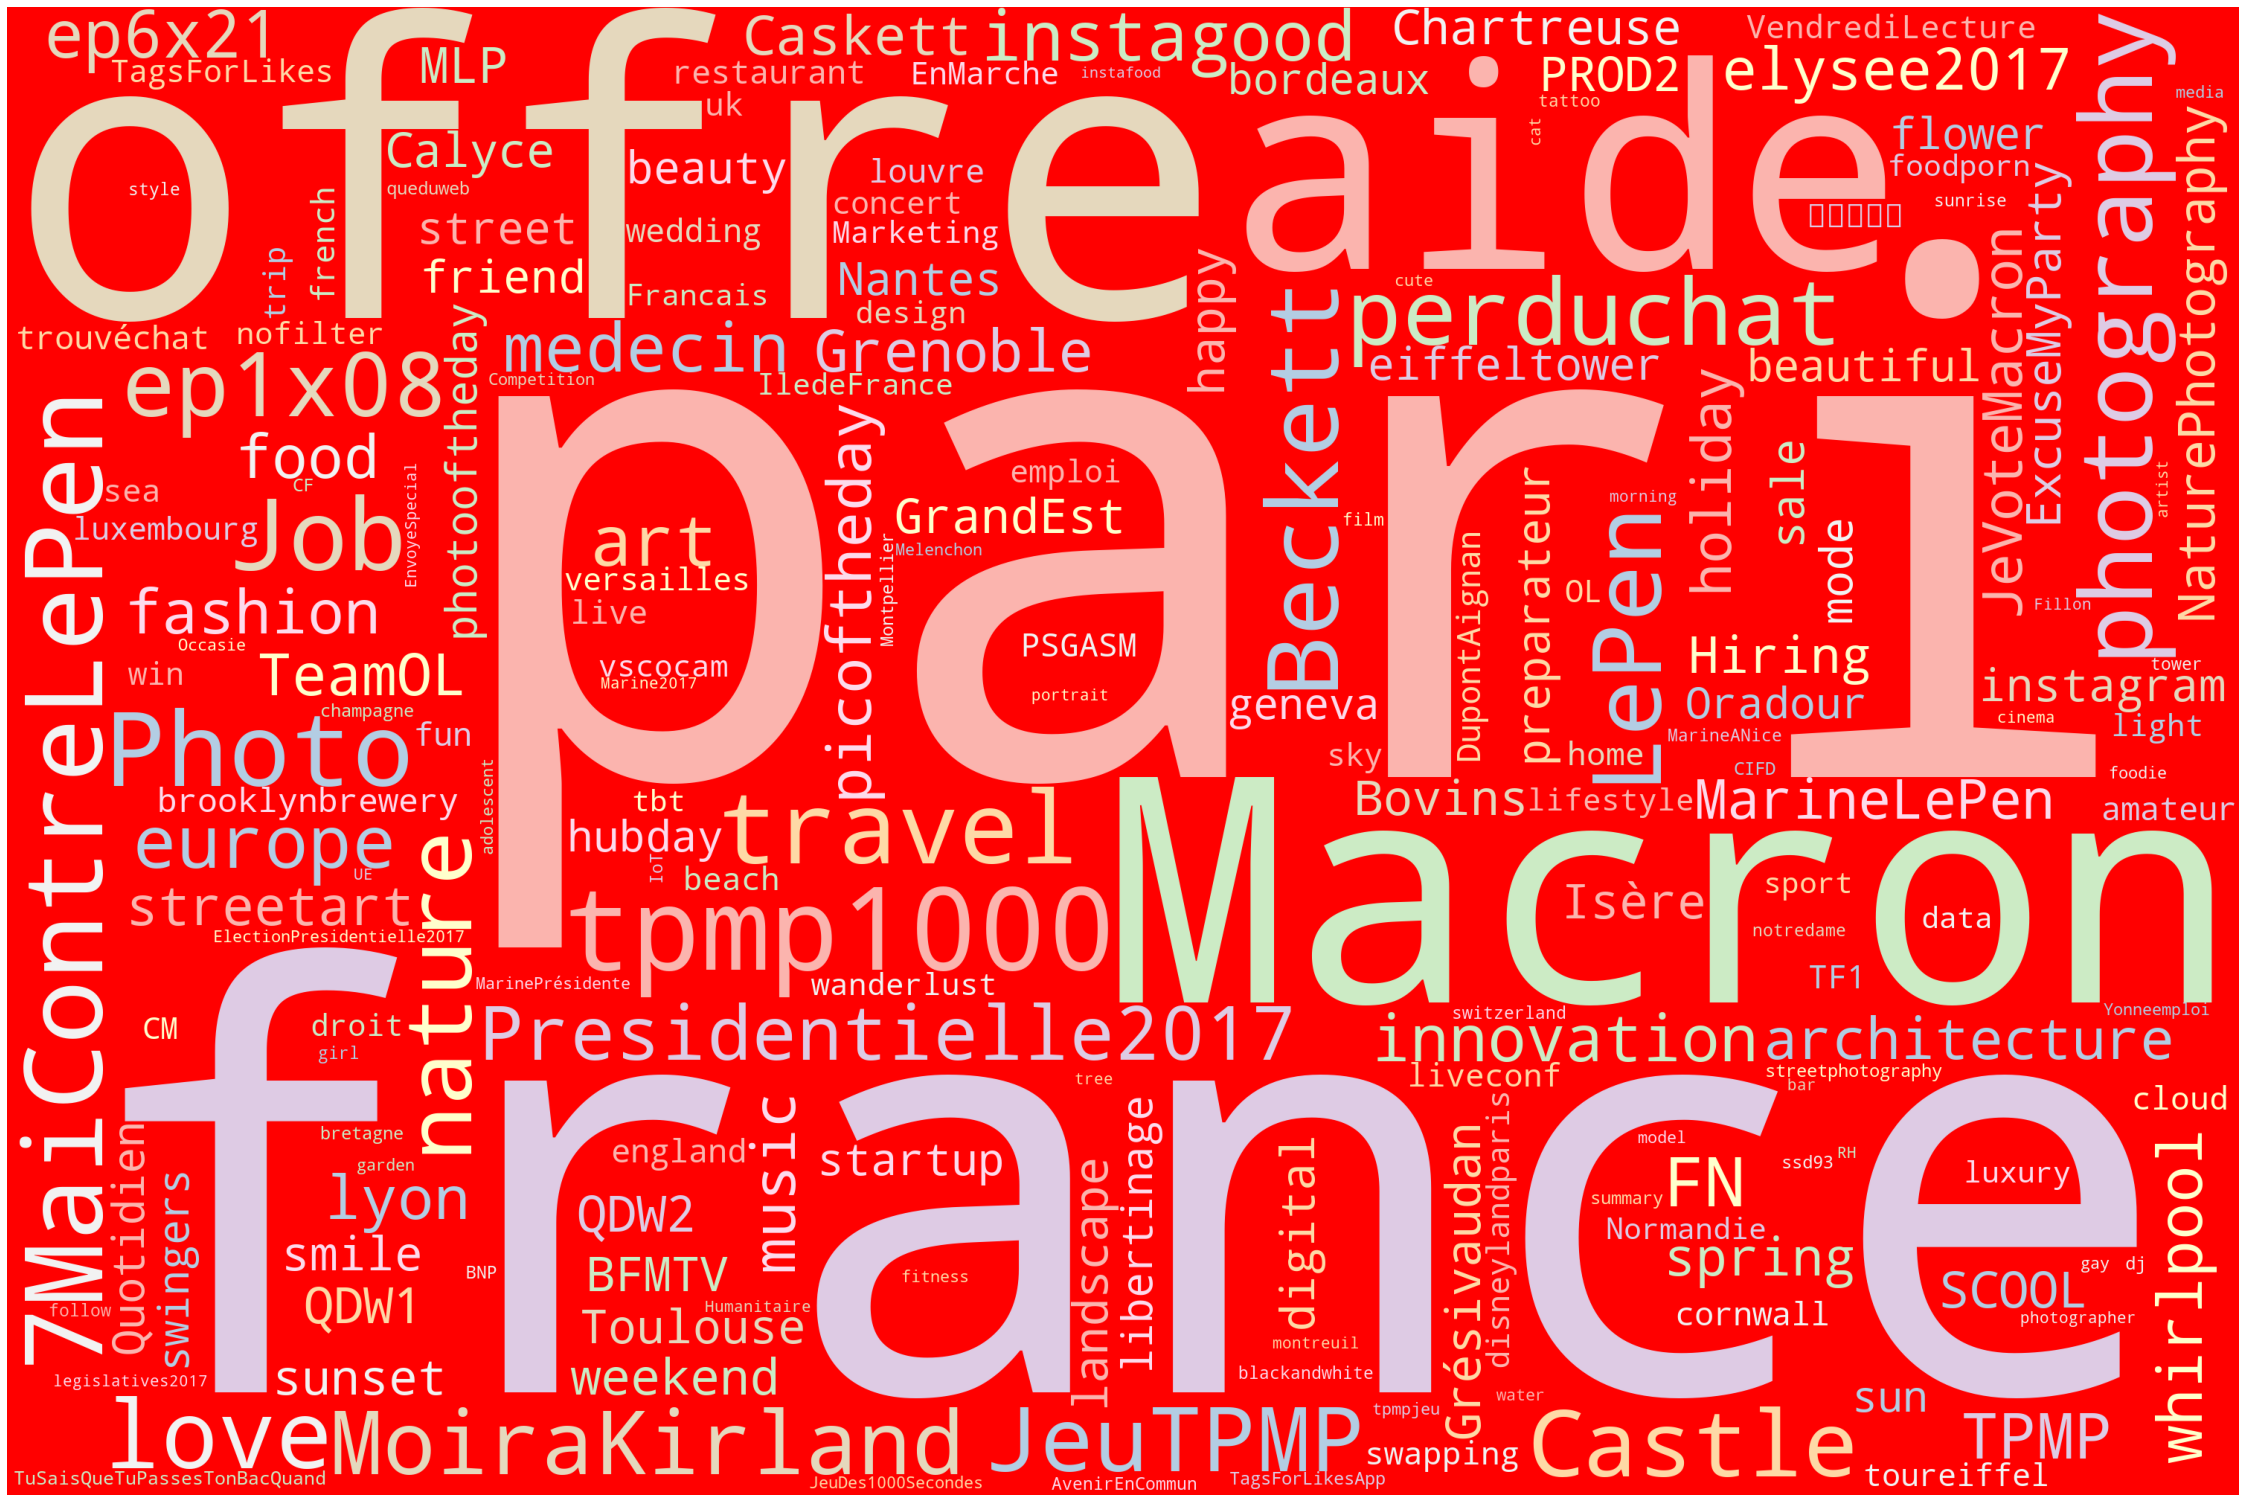

In [25]:
# hashtags cleaner function
def hashtags(h):
    if h:
        return ' '.join(h)
    else:
        return ''
hashtags_udf = F.udf(hashtags, StringType())
# add hashtags column
df_with_id = df_with_id.withColumn("hashtags", hashtags_udf(df_with_id["entities.hashtags.text"]))
# create tweets table
df_with_id.createOrReplaceTempView('tweets')
# Create word Cloud
hashtags = spark.sql("""SELECT hashtags FROM tweets""")
text = ''
for hash in hashtags.collect():
    text += hash.asDict()['hashtags']
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='red', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

## @Mentions wordcloud

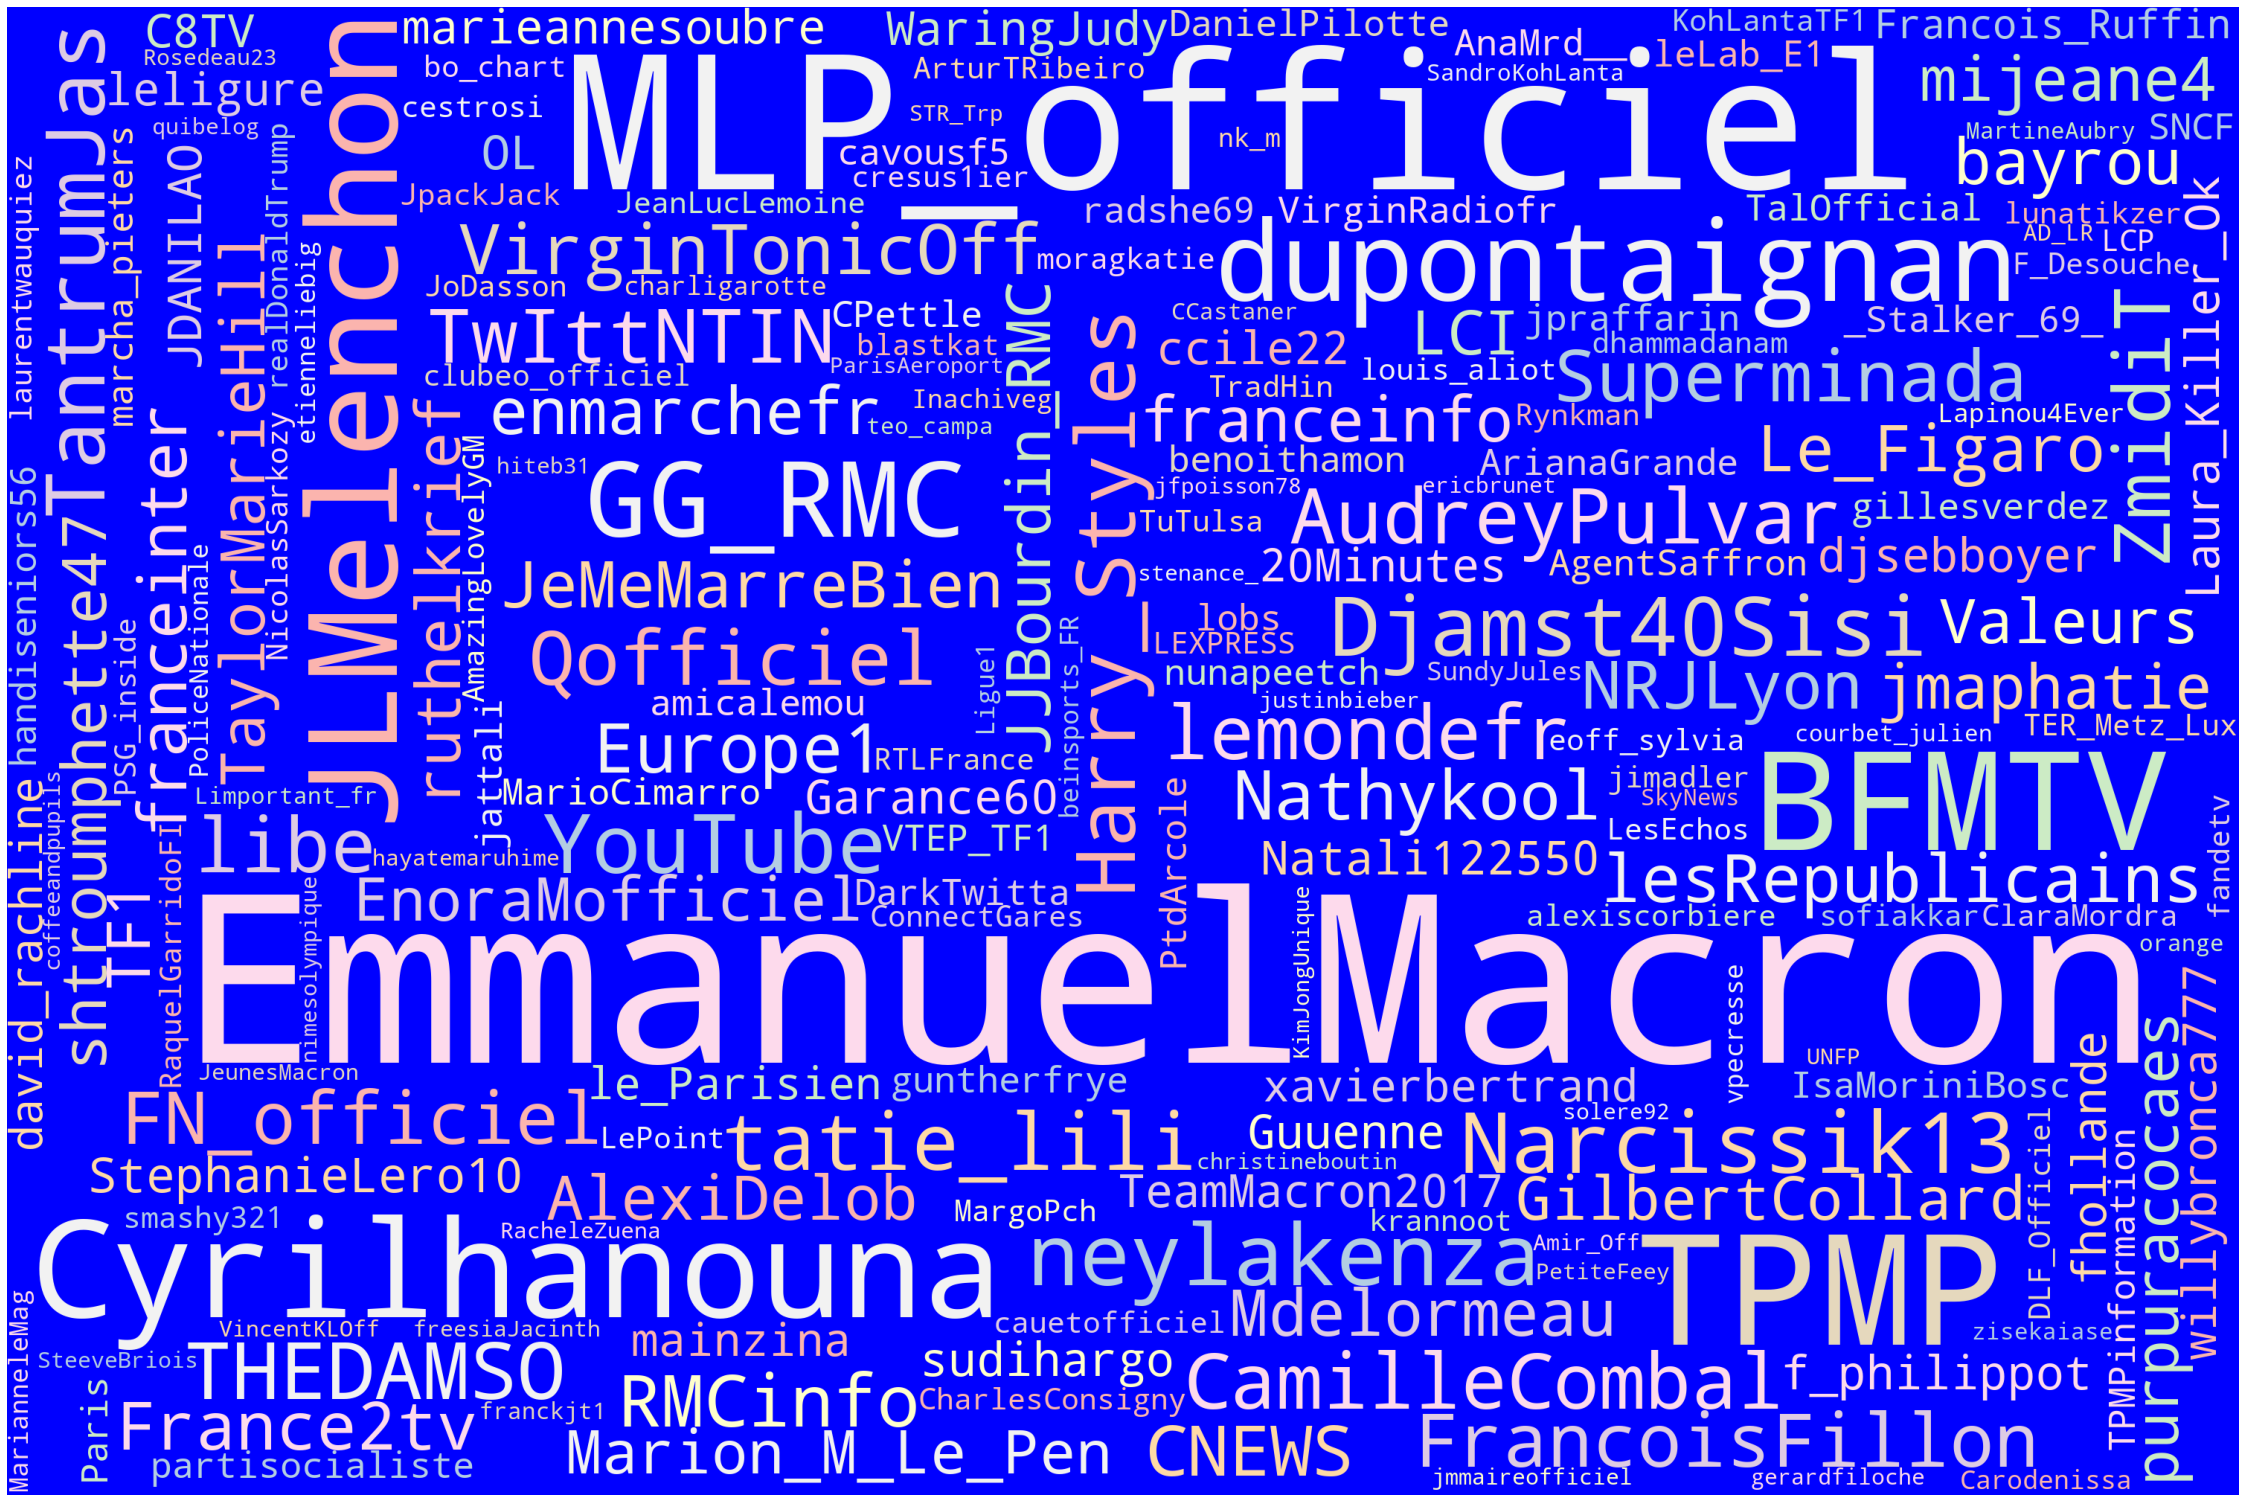

In [24]:
query = """SELECT entities.user_mentions.screen_name as mentions FROM tweets"""
mentions = spark.sql(query)
mentions_df = mentions.toPandas()
mentions_df.iloc[:,0]
all_mentions = ''
for mentions in mentions_df.iloc[:,0]:
    if mentions:
        for mention in mentions:
            all_mentions += ' ' + mention
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='blue', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(all_mentions)
# Plot
plot_cloud(wordcloud)